In [322]:
import pandas as pd 
import numpy as np
import scipy
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import pylab

import pandahouse as ph

import io
import requests
%matplotlib inline

# A/B-тестирование

## Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) \
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных \
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента \
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

## Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему? 
- Имеются ли различия в показателях и с чем они могут быть связаны? 
- Являются ли эти различия статистически значимыми? 
- Стоит ли запускать новую механику на всех пользователей? 

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

## Реализация

### Импорт наборов данных

In [2]:
groups = pd.read_csv('/Users/vitaly/Documents/!KC_Фин_Проект/Проект_2_groups.csv', sep = ';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.dtypes

id      int64
grp    object
dtype: object

In [5]:
groups.shape

(74484, 2)

In [10]:
active_studs = pd.read_csv('/Users/vitaly/Documents/!KC_Фин_Проект/Проект_2_active_studs.csv')

In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.dtypes

student_id    int64
dtype: object

In [13]:
active_studs.shape

(8341, 1)

In [14]:
checks = pd.read_csv('/Users/vitaly/Documents/!KC_Фин_Проект/Проект_2_checks.csv', sep = ';')

In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

_Проверим, почему столбцу rev присвоен тип float64_

In [17]:
checks.rev.unique()

array([ 990.    ,  690.    ,  630.    ,  580.    ,  290.    , 1140.    ,
       1900.0001,  199.    ,  398.    , 1830.    , 1900.    , 3260.    ,
       2910.    , 2820.    , 2099.    , 3660.    , 1530.    , 2900.    ,
       1980.    , 1160.    ,  870.    ,  840.    , 2890.    , 1180.    ,
        880.    , 3040.    ,  796.    , 4650.    , 2190.    , 1729.    ,
       1388.    ,  590.    , 2220.    ,  489.    , 1050.    , 1968.    ,
       1339.    ,  597.    , 1039.    ])

_Колонке rev (Revenue) соответствует тип float64, когда на деле ей достаточно int64 - заменим_

In [18]:
checks.rev = checks.rev.astype('int')

In [19]:
checks.head()

,student_id,rev
0,1627,990
1,3185,690
2,25973,690
3,26280,690
4,100300,990


### EDA

_Оценим размеры контрольной и тестовой групп:_

1. Проверим дубликаты в таблице groups

In [20]:
print('В таблице groups {} дубликатов'.format(groups[groups.duplicated()].shape[0]))

В таблице groups 0 дубликатов


2. Оценим размеры контрольной и тестовой групп

In [167]:
groups.groupby('grp').agg({'id': 'count'}) \
                            .rename(columns = {'id': 'count_of_students'})

,count_of_students
grp,
A,14671
B,59813


In [169]:
groups.groupby('grp').agg({'id': 'count'}) \
                            .rename(columns = {'id': 'percent_of_students'}) \
                            .apply(lambda x: x/groups.shape[0]) \
                            .mul(100) \
                            .round(1)         

,percent_of_students
grp,
A,19.7
B,80.3


- _Контрольная группа составляет 19,7% (14671 пользователь)_ 
- _Тестовая - 80,3% (59813 польз.)_

_Проверим наличие дубликатов в таблице active_studs_

In [28]:
print('В таблице active_studs {} дубликатов' \
      .format(active_studs[active_studs.duplicated()].shape[0]))

В таблице active_studs 0 дубликатов


_Проверим наличие дубликатов в таблице checks по столбцу student_id_

In [29]:
print('В таблице checks {} дубликатов' \
      .format(checks[checks.duplicated(subset = 'student_id')].shape[0]))

В таблице checks 0 дубликатов


### Выбор метрик для оценивания эксперимента

_Предложенные наборы данных располагают информацией об активных пользователях и прибыли (Revenue) с каждого из них, поэтому можно использовать следующий набор метрик:_

1) CR в покупку \
2) ARPPU \
3) ARPU 

_Конверсия в покупку (CR) интересна в первую очередь, так как тестируется новая механика оплаты услуг на сайте, успех которой лучше всего отобразим количеством покупателей._ \
_Средний доход с покупателя (ARPPU) и Средний доход с пользователя (ARPU) отразят то, как новая механика поощряет добавление товаров в корзину и удобство новой механики оплаты, её "привлекательность"._



### Рассчёт метрик

1) Рассчитаем CR в покупку для каждой группы

_Поскольку в таблице checks отсутствуют дубликаты, можно определить количество покупателей как число строк в этой таблице. \
По той же причине, но для таблицы active_studs, воспользуемся количеством строк в ней для определения количества пользователей._


1.1 Объединим таблицы checks и groups для возможности фильтрации покупателей по группе 

In [170]:
checks_merged = checks.merge(groups.rename(columns = {'id': 'student_id'}), 
                             on = 'student_id')

In [171]:
checks_merged.head()

,student_id,rev,grp
0,1627,990,A
1,3185,690,B
2,25973,690,B
3,26280,690,B
4,100300,990,B


1.2 Объединим таблицы active_studs и groups для возможности фильтрации пользователей по группам

In [172]:
active_studs_merged = active_studs.merge(groups.rename(columns = {'id': 'student_id'}),
                                        on = 'student_id')

In [174]:
active_studs_merged.head()

,student_id,grp
0,581585,A
1,3276743,B
2,4238589,A
3,4475369,B
4,5481015,B


1.3 Посчитаем CR в покупку для каждой группы

Контрольная группа:

In [175]:
CR_A = checks_merged.query('grp == "A"').shape[0] / \
       active_studs_merged.query('grp == "A"').shape[0]

In [176]:
CR_A_perc_round = round(CR_A * 100, 1)

In [177]:
print('Конверсия в покупку в период проведения эксперимента для контрольной группы составила {}%' \
      .format(CR_A_perc_round))

Конверсия в покупку в период проведения эксперимента для контрольной группы составила 7.0%


Тестовая группа:

In [178]:
CR_B = checks_merged.query('grp == "B"').shape[0] / \
       active_studs_merged.query('grp == "B"').shape[0]

In [179]:
CR_B_perc_round = round(CR_B * 100, 1)

In [181]:
print('Конверсия в покупку в период проведения эксперимента для тестовой группы составила {}%' \
      .format(CR_B_perc_round))

Конверсия в покупку в период проведения эксперимента для тестовой группы составила 6.4%


2) Рассчитаем ARPPU

_Поскольку в таблице checks нет дубликатов, можно предполагать, что покупатели совершили по одной покупке, либо хранится информация о сумме всех заказов. \
Тогда просто необходимо рассчитать средний чек._

Контрольная группа:

In [182]:
ARPPU_A = round(checks_merged.query('grp == "A"').rev.sum() / \
                checks_merged.query('grp == "A"').shape[0],
                1)

In [183]:
print('ARPPU в период проведения эксперимента для контрольной группы составил {} у.е.' \
      .format(ARPPU_A))

ARPPU в период проведения эксперимента для контрольной группы составил 860.7 у.е.


Тестовая группа:

In [184]:
ARPPU_B = round(checks_merged.query('grp == "B"').rev.sum() / \
                checks_merged.query('grp == "B"').shape[0],
                1)

In [185]:
print('ARPPU в период проведения эксперимента для тестовой группы составил {} у.е.' \
      .format(ARPPU_B))

ARPPU в период проведения эксперимента для тестовой группы составил 1107.0 у.е.


3) ARPU

_Перемножим конверсию в покупку с ARPPU_

3.1 Контрольная группа:

In [186]:
ARPU_A = round(CR_A * ARPPU_A,
               1)

In [187]:
print('ARPU в период проведения эксперимента для контрольной группы составил {} у.е.' \
      .format(ARPU_A))

ARPU в период проведения эксперимента для контрольной группы составил 60.0 у.е.


3.2 Тестовая группа

In [188]:
ARPU_B = round(CR_B * ARPPU_B,
               1)

In [189]:
print('ARPU в период проведения эксперимента для тестовой группы составил {} у.е.' \
      .format(ARPU_B))

ARPU в период проведения эксперимента для тестовой группы составил 70.6 у.е.


_Конверсия у тестовой группы меньше на 0.6%, однако ARPPU и ARPU больше на 246.3 и 10.6 у.е. соответственно. \
Можно сделать вывод, что новая механика оплаты услуг лучше мотивирует добавлять больше товаров в корзину и/или более дорогие, однако хуже доводит до покупки._  


### Проверка статистической значимости отличий

#### CR

_Рассчитаем доверительные интервалы показателя конверсии для каждой группы, а затем посчитаем доверительный интервал разницы. Если он будет содержать нулевое значение, разница будет статистически незначимой._

1. Доверительные интервалы конверсии для каждой группы

In [190]:
n_A_group = active_studs_merged.query('grp == "A"').shape[0] # размер выборки группы A 

In [192]:
n_B_group = active_studs_merged.query('grp == "B"').shape[0] # размер выборки группы B 

In [193]:
conf_int_low_A = round((CR_A - 1.96 * np.sqrt( (CR_A * (1 - CR_A)) / n_A_group)) * 100, 
                       1)
                       

In [194]:
conf_int_high_A = round((CR_A + 1.96 * np.sqrt( (CR_A * (1 - CR_A)) / n_A_group)) * 100, 
                        1)

In [195]:
conf_int_low_B = round((CR_B - 1.96 * np.sqrt( (CR_B * (1 - CR_B)) / n_B_group)) * 100, 
                       1)

In [196]:
conf_int_high_B = round((CR_B + 1.96 * np.sqrt( (CR_B * (1 - CR_B)) / n_B_group)) * 100, 
                        1)

In [197]:
print('С вероятностью 95% конверсия в контрольной группе лежит в интервале [{}% ; {}%]' \
      .format(conf_int_low_A, conf_int_high_A))

С вероятностью 95% конверсия в контрольной группе лежит в интервале [5.7% ; 8.2%]


In [198]:
print('С вероятностью 95% конверсия в тестовой группе лежит в интервале [{}% ; {}%]' \
      .format(conf_int_low_B, conf_int_high_B))

С вероятностью 95% конверсия в тестовой группе лежит в интервале [5.8% ; 7.0%]


2. Доверительный интервал разницы (в процентах)

In [199]:
conf_int_diff_low = round((CR_B - CR_A - \
                           1.96 * np.sqrt( ((CR_A * (1 - CR_A)) / n_A_group) + \
                                           ((CR_B * (1 - CR_B)) / n_B_group)
                                         ))
                          *100,
                          1)

In [200]:
conf_int_diff_high = round((CR_B - CR_A + \
                            1.96 * np.sqrt( ((CR_A * (1 - CR_A)) / n_A_group) + \
                                            ((CR_B * (1 - CR_B)) / n_B_group)
                                          ))
                          *100,
                          1)

In [201]:
print('Ухудшение в конверсии с вероятностью 95% лежит в интервале [{}% ; {}%]' \
      .format(conf_int_diff_low, conf_int_diff_high))

Ухудшение в конверсии с вероятностью 95% лежит в интервале [-2.0% ; 0.8%]


_Вывод: интервал ухудшения конверсии содержит нулевое значение, поэтому делаем вывод, что конверсия снизилась статистически незначимо_

#### ARPPU

_Исследуем распределение дохода с покупателей, чтобы выбрать правильный статистический критерий для сравнения._

Контрольная группа

<AxesSubplot:xlabel='rev', ylabel='Count'>

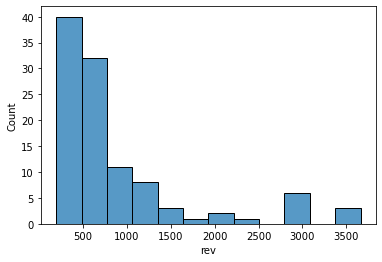

In [202]:
sns.histplot(checks_merged.query('grp == "A"').rev)

Тестовая группа

<AxesSubplot:xlabel='rev', ylabel='Count'>

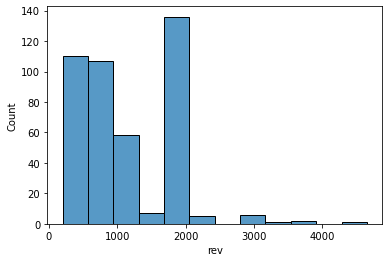

In [203]:
sns.histplot(checks_merged.query('grp == "B"').rev)

_Очевидно, что обе группы визуально имеют НЕ нормальное распределение, однако примерно одинаковое, поэтому воспользуемся U-тестом Манна-Уитни (alpha = 0.05)._

In [204]:
stat, p_value = scipy.stats.mannwhitneyu(checks_merged.query('grp == "A"').rev,
                                         checks_merged.query('grp == "B"').rev)

print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=17850.0000, p-value=0.0001


_p-value значительно ниже 0.05 - делаем вывод, что средний доход с покупателя между группами различается статистически значимо._

#### ARPU

_Объединим таблицы groups_concat и checks методов LEFT с целью оставить всех пользователей и добавить доход только к покупателям, остальным присвоим ноль._

In [205]:
users_with_rev = groups_concat.rename(columns = {'id': 'student_id'}) \
                              .merge(checks, on = 'student_id', how = 'left') \
                              .fillna(0)

In [206]:
users_with_rev.head()

,student_id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


_Визуально оценим распределение дохода по пользователям_

Контрольная группа

<AxesSubplot:xlabel='rev', ylabel='Count'>

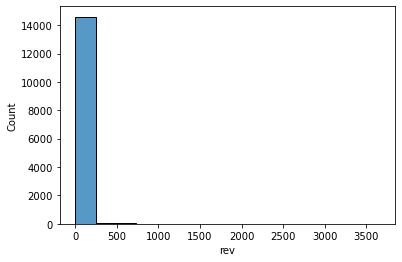

In [207]:
sns.histplot(users_with_rev.query('grp == "A"').rev)

Тестовая группа

<AxesSubplot:xlabel='rev', ylabel='Count'>

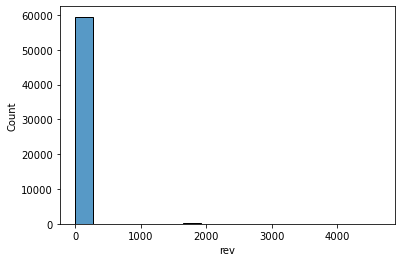

In [208]:
sns.histplot(users_with_rev.query('grp == "B"').rev)

_Так как распределения одинаковые, вновь применим U-тестом Манна-Уитни (alpha = 0.05)_

In [209]:
stat, p_value = scipy.stats.mannwhitneyu(users_with_rev.query('grp == "A"').rev,
                                         users_with_rev.query('grp == "B"').rev)

print(f" Mann–Whitney U Test: statistic = {stat:.4f}, p-value = {p_value:.4f}")

 Mann–Whitney U Test: statistic = 439920457.0000, p-value = 0.4884


_p-value больше 0.05 - делаем вывод, что средний доход с пользователя между группами различается статистически НЕзначимо._ 

_Таким образом, по результатам АБ тестирования можно утверждать, что новая механика оплаты услуг лучше предыдущей, так как значимо повысила средний доход с покупателя._ 

# SQL

## "Очень усердные ученики"

### Условие

_Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной"._

_Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин._

### Задача

_Дана таблица default.peas:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|timesst||timestamp||Время решения карточки|
|correct||bool||Правильно ли решена горошина?|
|subject||text||Дисциплина в которой находится горошина|


_Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов._ \
_Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц._

### Реализация

_Настройки подключения к базе данных_

In [146]:
connection_default = {'host':     'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user':     'student', 
                      'password': 'dpo_python_2020'}

**Запрос к БД**


In [333]:
query_1 = """

WITH 
    (
    SELECT 
        month(max(timest))  
     FROM 
        default.peas
    ) as last_date              -- последняя дата в таблице
    
SELECT
    COUNT(*) as count_of_students                     
FROM
    (
    SELECT 
        st_id,
        sum(correct) as count_of_gor
    FROM
        default.peas
    WHERE
        month(timest) = last_date     
    GROUP BY 
        st_id
    HAVING 
        count_of_gor >= 20                             -- отсечение количества правильно решённых задач меньше 20
    )

"""

In [334]:
result_query_1 = ph.read_clickhouse(query = query_1, 
                               connection = connection_default)

In [335]:
result_query_1

,count_of_students
0,136


In [336]:
print(f'{result_query_1.iloc[0][0]} студентов являются очень усердными, то есть решили как минимум 20 задач за текущий месяц')

136 студентов являются очень усердными, то есть решили как минимум 20 задач за текущий месяц


## Оптимизация воронки

### Условие

_Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты._

### Задача

_Даны таблицы_ 

_default.peas:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|timesst||timestamp||Время решения карточки|
|correct||bool||Правильно ли решена горошина?|
|subject||text||Дисциплина в которой находится горошина|


\
_default.studs:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|test_grp||text||Метка ученика в данном эксперименте|


\
_default.final_project_check:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|saletime||timestamp||Время покупки|
|money||int||Цена, по которой приобрели данный курс|
|subject||text|||

_Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:_

- _ARPU_ 
- _ARPAU_
- _CR в покупку_ 
- _СR активного пользователя в покупку_ 
- _CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике_

_ARPU считается относительно всех пользователей, попавших в группы._

_Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах._

_Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике._

### Реализация

**Запрос к БД**

In [315]:
query_2 = """

SELECT 
    A.group_test as group_test,
    ARPU,
    ARPAU,
    CR, 
    CR_act,
    CR_act_math
FROM
    (
    SELECT 
        test_grp as group_test,
        AVG(money) as ARPU
    FROM 
        default.studs as studs
        LEFT JOIN 
            default.final_project_check as check
        ON 
            check.st_id = studs.st_id
    GROUP BY
        test_grp
    ) as A
    
INNER JOIN

    (
    SELECT 
        test_grp as group_test,
        AVG(money) as ARPAU
    FROM 
        default.studs as studs
        LEFT JOIN 
            default.final_project_check as check
        ON 
            check.st_id = studs.st_id
        INNER JOIN (
            SELECT
                first_value(st_id) as student_id,
                SUM(correct) as sum_tasks_done  
            FROM 
                default.peas 
            GROUP BY    
                st_id
            HAVING 
                sum_tasks_done > 10
            ) as peas
        ON  
            studs.st_id = peas.student_id
    GROUP BY
        test_grp
    ) as B
    
ON
    A.group_test = B.group_test
    
INNER JOIN

    (
    SELECT 
        group_test,
        CR_ch / CR_zn * 100 as CR
    FROM 
        (
        SELECT 
            first_value(test_grp) as group_test,
            COUNT(DISTINCT st_id) CR_ch
        FROM 
            default.studs as studs
            LEFT JOIN 
                default.final_project_check as check
            ON 
                check.st_id = studs.st_id
        WHERE 
            money != 0
        GROUP BY 
            test_grp
        ) AS A
        
        INNER JOIN
        
        (
        SELECT 
            first_value(test_grp) as group_test,
            COUNT(DISTINCT st_id) as CR_zn
        FROM 
            default.studs
        GROUP BY 
            test_grp
        ) AS B
        
        ON
        A.group_test = B.group_test
    ) as C

ON
    B.group_test = C.group_test

INNER JOIN 
    
    (
    SELECT 
        group_test,
        CR_act_ch / CR_act_zn * 100 as CR_act
    FROM 
        (
        SELECT 
            group_test,
            COUNT(DISTINCT st_id) as CR_act_ch
        FROM
            (SELECT
                st_id
            FROM
                default.final_project_check
            WHERE 
                money != 0) as check
                
                INNER JOIN
                    
            (SELECT
                st_id as student_id,
                SUM(correct) as sum_tasks_done
            FROM 
                default.peas
            GROUP BY
                st_id
            HAVING 
                sum_tasks_done > 10) as active_users
                    
                ON
            check.st_id = active_users.student_id
                
                INNER JOIN
                
            (SELECT
                st_id as student_id,
                test_grp as group_test
            FROM
                default.studs
            ) as studs
                
                ON
            check.st_id = studs.student_id
        GROUP BY 
            group_test
        ) AS A
        
        INNER JOIN
        
        (
        SELECT 
            group_test,
            COUNT(DISTINCT student_id) as CR_act_zn
        FROM
            (SELECT
                st_id as student_id,
                SUM(correct) as sum_tasks_done
            FROM 
                default.peas
            GROUP BY
                st_id
            HAVING 
                sum_tasks_done > 10) as active_users
                
                INNER JOIN
                
            (SELECT
                st_id as student_id,
                test_grp as group_test
            FROM
                default.studs
            ) as studs
                
                ON
            active_users.student_id = studs.student_id
        GROUP BY 
            group_test
        ) AS B
        
        ON
        A.group_test = B.group_test
    ) as D
    
ON
    C.group_test = D.group_test
    
INNER JOIN

    (
    SELECT 
    group_test,
    CR_act_pay_math / CR_act_math * 100 as CR_act_math
    FROM 
    (
    SELECT 
        group_test,
        COUNT(DISTINCT st_id) as CR_act_pay_math
    FROM
        (SELECT
            st_id
        FROM
            default.final_project_check
        WHERE 
            money != 0) as check
            
            INNER JOIN
                
        (SELECT
            st_id as student_id,
            SUM(correct) as sum_tasks_done
        FROM 
            default.peas
        WHERE
            subject = 'Math'
        GROUP BY
            st_id
        HAVING 
            sum_tasks_done >= 2) as active_users
                
            ON
        check.st_id = active_users.student_id
            
            INNER JOIN
            
        (SELECT
            st_id as student_id,
            test_grp as group_test
        FROM
            default.studs
        ) as studs
            
            ON
        check.st_id = studs.student_id
    GROUP BY 
        group_test
    ) AS A
    
    INNER JOIN
    
    (
    SELECT 
        group_test,
        COUNT(DISTINCT student_id) as CR_act_math
    FROM
        (SELECT
            st_id as student_id,
            SUM(correct) as sum_tasks_done
        FROM 
            default.peas
        WHERE 
            subject = 'Math'
        GROUP BY
            st_id
        HAVING 
            sum_tasks_done >= 2) as active_users
            
            INNER JOIN
            
        (SELECT
            st_id as student_id,
            test_grp as group_test
        FROM
            default.studs
        ) as studs
            
            ON
        active_users.student_id = studs.student_id
    GROUP BY 
        group_test
    ) AS B
    
    ON
    A.group_test = B.group_test
    ) as E
    
ON D.group_test = E.group_test

"""

In [316]:
result_query_2 = ph.read_clickhouse(query = query_2, 
                               connection = connection_default)

In [317]:
result_query_2

,group_test,ARPU,ARPAU,CR,CR_act,CR_act_math
0,control,4496.753247,10153.846154,4.918033,11.023622,10.204082
1,pilot,11094.771242,26933.962264,10.847458,26.041667,14.285714


# Python

## Функция подгрузки информации и пересчёта метрик

### Задача
_Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики._

### Реализация

In [313]:
def updating_info(new_df_link):
    groups_add = pd.read_csv(new_df_link, names = ['id', 'grp'])
    
    # Объединение таблиц вертикально
    frames = [groups, groups_add] 
    groups_concat = pd.concat(frames).drop_duplicates() 
    
    # Объединение таблиц для рассчёта
    checks_merged = checks.merge(groups_concat.rename(columns = {'id': 'student_id'}), 
                             on = 'student_id')
    active_studs_merged = active_studs.merge(groups_concat.rename(columns = {'id': 'student_id'}),
                                        on = 'student_id')
    
    # Конверсия
    CR_A = checks_merged.query('grp == "A"').shape[0] / \
     active_studs_merged.query('grp == "A"').shape[0]
    CR_A_perc_round = round(CR_A * 100, 1)
    print('Конверсия в покупку в период проведения эксперимента для контрольной группы составила {}%' \
      .format(CR_A_perc_round))
    
    CR_B = checks_merged.query('grp == "B"').shape[0] / \
       active_studs_merged.query('grp == "B"').shape[0]
    CR_B_perc_round = round(CR_B * 100, 1)
    print('Конверсия в покупку в период проведения эксперимента для тестовой группы составила {}%' \
      .format(CR_B_perc_round))
    
    # ARPPU 
    ARPPU_A = round(checks_merged.query('grp == "A"').rev.sum() / \
                    checks_merged.query('grp == "A"').shape[0],
                    1)
    print('ARPPU в период проведения эксперимента для контрольной группы составил {} у.е.' \
      .format(ARPPU_A))
    ARPPU_B = round(checks_merged.query('grp == "B"').rev.sum() / \
                    checks_merged.query('grp == "B"').shape[0],
                    1)
    print('ARPPU в период проведения эксперимента для тестовой группы составил {} у.е.' \
      .format(ARPPU_B))
    
    # ARPU
    ARPU_A = round(CR_A * ARPPU_A,
                   1)
    print('ARPU в период проведения эксперимента для контрольной группы составил {} у.е.' \
      .format(ARPU_A))
    ARPU_B = round(CR_B * ARPPU_B,
                   1)
    print('ARPU в период проведения эксперимента для тестовой группы составил {} у.е.' \
      .format(ARPU_B))

In [314]:
updating_info('/Users/vitaly/Documents/!KC_Фин_Проект/Проект_2_group_add.csv')

Конверсия в покупку в период проведения эксперимента для контрольной группы составила 7.0%
Конверсия в покупку в период проведения эксперимента для тестовой группы составила 6.4%
ARPPU в период проведения эксперимента для контрольной группы составил 860.7 у.е.
ARPPU в период проведения эксперимента для тестовой группы составил 1107.0 у.е.
ARPU в период проведения эксперимента для контрольной группы составил 60.0 у.е.
ARPU в период проведения эксперимента для тестовой группы составил 70.6 у.е.


## Функция визуализации метрик

### Задача
_Реализуйте функцию, которая будет строить графики по получаемым метрикам._

### Реализация

In [309]:
def visual_metrics():
        # Датафрейм для визуализации
    # параметры
    df_par = {'metric': ['CR', 
                         'CR', 
                         'ARPPU', 
                         'ARPPU',
                         'ARPU', 
                         'ARPU'],
               'group': ['control', 
                         'test',
                         'control', 
                         'test',
                         'control', 
                         'test',],
               'value': [CR_A_perc_round, 
                         CR_B_perc_round, 
                         ARPPU_A, 
                         ARPPU_B,
                         ARPU_A, 
                         ARPU_B]
             }

    # создание
    metrics_df = pd.DataFrame(data = df_par)
    
        # Визуализация
    plt.figure(figsize = (17, 4))

    # конверсия
    plt.subplot(1, 3, 1)
    plt.bar(data = metrics_df.iloc[0:2],
            x = 'group',
            height = 'value',
            color = 'brown'
           )
    plt.title('Конверсия')
    plt.ylabel('Значение(%)')

    # ARPPU
    plt.subplot(1, 3, 2)
    plt.bar(data = metrics_df.iloc[2:4],
            x = 'group',
            height = 'value',
            color = 'green'
           )
    plt.title('ARPPU')
    plt.ylabel('Значение')

    # ARPU
    plt.subplot(1, 3, 3)
    plt.bar(data = metrics_df.iloc[4:6],
            x = 'group',
            height = 'value',
            color = 'green'
           )
    plt.title('ARPU')
    plt.ylabel('Значение')

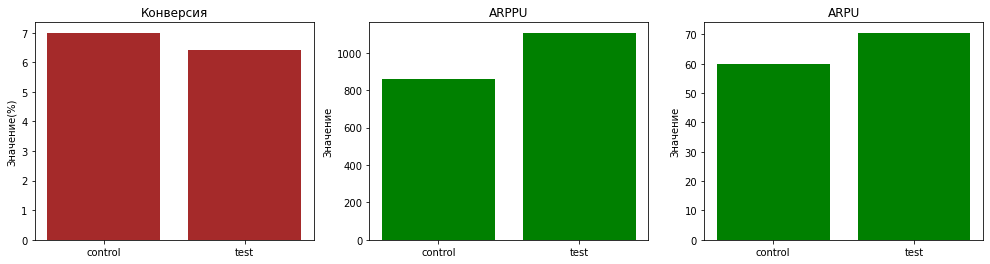

In [310]:
visual_metrics()